AML Project (Survival Prediction) Neural Network Model

We will use the first block of code to import all the required libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import (accuracy_score, 
                            roc_auc_score, roc_curve, auc)
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# import shap
pd.set_option('display.max_rows', 250)

We will then load the hospital patient survival dataset into our notebook.

In [70]:
from google.colab import files 
uploadfile = files.upload()

Saving dataset.csv to dataset (1).csv


We will then read that file

In [71]:
import io
hospital_ds = pd.read_csv(io.BytesIO(uploadfile['dataset.csv']))

We will check the dimensions of the dataset

In [72]:
hospital_ds.shape

(91713, 85)

We will then check the columns that have a lot of missing values. Here we will be using a threshold of 25000 missing values

In [73]:
high_missing= hospital_ds.isnull().sum(axis=0)[hospital_ds.isnull().sum(axis=0) > 25000]
len(high_missing)

1

Since this column has a very ;arge proportion of missing values, we can drop this column with such a large number of missing values

In [74]:
hospital_ds.drop(high_missing.index.tolist(), axis=1,inplace = True)
             

In addition , there are some columns which do not serve as any sort of predictors , so we will drop them too.

In [75]:
hospital_ds.drop(['encounter_id', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id'],axis=1,inplace = True)

We will now make a list of columns with numerical data.

In [76]:
numerical_features=[]
for col in hospital_ds.columns:
    if (hospital_ds[col].dtype==int)or (hospital_ds[col].dtype==float):
        numerical_features.append(col)

We will now replace the missing values in these columns by using the median. (The analysis has been done in the EDA notebook)

In [77]:
for col in hospital_ds.columns:
    if col in numerical_features :
        hospital_ds[col].fillna(hospital_ds[col].median(), inplace=True)

We will now handle the categorical data. The first step being we will sepearate out the columns that have numerical categorical data and the ones that have string categorical data.

In [78]:
numcategory = [
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

categorical = ['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

We will create lists of columns with and without the categorical data


In [79]:
nnvar = hospital_ds[numcategory + categorical + ['hospital_death']].columns.tolist()
numericvar = hospital_ds.drop(nnvar,axis=1).columns.tolist()

  We will replace the missing values in the categorical column using the mode.

In [80]:
for column in numcategory:
    hospital_ds[column] = hospital_ds[column].astype('Int64')
for column in numcategory:
    hospital_ds[column] = hospital_ds[column].fillna(hospital_ds[column].mode()[0])

In case, there are any missing values in the dataset after filling in the columns with median/mode , we will drop those rows

In [81]:
finalds = hospital_ds.dropna(axis=0)

We will now handle the categorical variables by performing one-hot encoding

In [82]:
hospital_data = pd.get_dummies(finalds,prefix='isin',prefix_sep='_',columns=categorical,drop_first=False)
hospital_data.reset_index(drop = True, inplace = True)
hospital_data.columns = [x.lower() for x in hospital_data.columns.tolist()]
hospital_data = hospital_data.loc[:,~hospital_data.columns.duplicated()]
t = hospital_data['arf_apache'].dtype
for columns in (hospital_data.columns.tolist()):
    if hospital_data[columns].values.dtype == 'uint8' or t == hospital_data[columns].values.dtype:
        hospital_data[columns] = hospital_data[columns].astype(int)

We will now prepare the training and the test sets for the model (Since there are such a large number of features and so many values , we will be limiting the model to operate only on the important features)

In [83]:
X = hospital_data.drop(['hospital_death'], axis=1)
y = hospital_data['hospital_death']

X_new = X[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','age','d1_spo2_min','d1_resprate_max','d1_heartrate_min']]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, random_state=11, stratify = y)

We will now define the layers of our sequential model:

In [84]:
model = Sequential()
model.add(Dense(10, input_dim=6, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(30, activation='softmax'))
model.add(Dense(1,activation='sigmoid'))

In [85]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                70        
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                                 
 dense_14 (Dense)            (None, 30)                180       
                                                                 
 dense_15 (Dense)            (None, 1)                 31        
                                                                 
Total params: 336
Trainable params: 336
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
import tensorflow as tf
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)

In [87]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [88]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=20, batch_size=64)

Epoch 1/20
970/970 [==============================] - 5s 5ms/step - loss: 0.3872 - accuracy: 0.9039 - val_loss: 0.3009 - val_accuracy: 0.9135
Epoch 2/20
970/970 [==============================] - 4s 4ms/step - loss: 0.2813 - accuracy: 0.9135 - val_loss: 0.2691 - val_accuracy: 0.9135
Epoch 3/20
970/970 [==============================] - 4s 4ms/step - loss: 0.2594 - accuracy: 0.9135 - val_loss: 0.2550 - val_accuracy: 0.9135
Epoch 4/20
970/970 [==============================] - 4s 4ms/step - loss: 0.2388 - accuracy: 0.9167 - val_loss: 0.2515 - val_accuracy: 0.9162
Epoch 5/20
970/970 [==============================] - 4s 4ms/step - loss: 0.2303 - accuracy: 0.9173 - val_loss: 0.2357 - val_accuracy: 0.9165
Epoch 6/20
970/970 [==============================] - 4s 4ms/step - loss: 0.2270 - accuracy: 0.9189 - val_loss: 0.2299 - val_accuracy: 0.9224
Epoch 7/20
970/970 [==============================] - 4s 4ms/step - loss: 0.2243 - accuracy: 0.9224 - val_loss: 0.2230 - val_accuracy: 0.9235
Epoch 

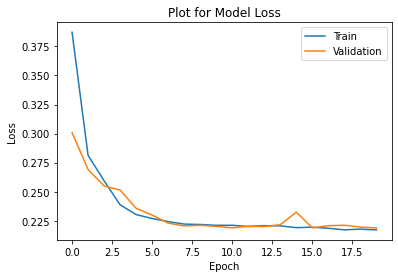

In [89]:
#a. displaying train vs validation loss over each epoch
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Plot for Model Loss')  
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right') 
plt.show()

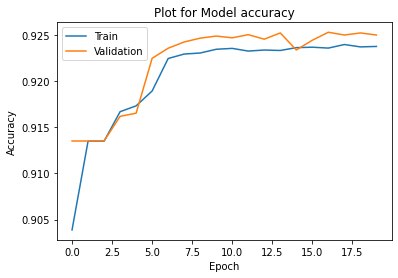

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot for Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We will now prepare the predictions for evaluationg the model performance

In [91]:
predict_x=model.predict(X_test) 
predictions = (model.predict(X_test) > 0.5).astype("int32")

# We will reduce the above arrays to 1d array
yhat_probs = predict_x[:, 0]
yhat_classes = predictions[:, 0]

832/832 [==============================] - 1s 1ms/step


In [92]:
accuracy = accuracy_score(y_test, yhat_classes)
print('The accuracy of the model on the Test dataset is %f' % accuracy)

The accuracy of the model on the Test dataset is 0.924965


In [93]:
precision = precision_score(y_test, yhat_classes)
print('The precision of the model on the Test dataset is %f' % precision)

The precision of the model on the Test dataset is 0.680473


In [94]:
recall = recall_score(y_test, yhat_classes)
print('The recall of the model on the Test dataset is %f' % recall)

The recall of the model on the Test dataset is 0.249891


In [95]:
f1 = f1_score(y_test, yhat_classes)
print('The f1 score of the model on the Test dataset is %f' % f1)

The f1 score of the model on the Test dataset is 0.365544


In [96]:
auc = roc_auc_score(y_test, yhat_probs)
print('The ROC AUC of the model on the Test dataset is %f' % auc)

The ROC AUC of the model on the Test dataset is 0.850812
